### Imports

In [1]:
import torch
import torch.nn as nn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import umap
from src.model import MFMViT

c:\Users\admin\miniconda3\envs\deepfake-detection\Lib\site-packages\torchvision\io\image.py:14: UserWarning: Failed to load image Python extension: 'Could not load this library: C:\Users\admin\miniconda3\envs\deepfake-detection\Lib\site-packages\torchvision\image.pyd'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
def get_features(model, dataloader, device):
    model.eval()
    features, labels = [], []
    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(device)
            tokens = model.encoder(images)
            tokens = tokens[:, 1:, :].mean(dim=1)
            features.append(tokens.cpu().numpy())
            labels.append(targets.numpy())
    return np.concatenate(features), np.concatenate(labels)


In [4]:
from torchvision import datasets, transforms

img_size = 224
batch_size = 16

transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder('E:/data/train', transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

test_dataset = datasets.ImageFolder('E:/data/val', transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")


Train samples: 21375, Test samples: 6197


In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = MFMViT().to(device)
model.load_state_dict(torch.load('checkpoints/mfm_vit_final.pth'))

train_features, train_labels = get_features(model, train_loader, device)
test_features, test_labels = get_features(model, test_loader, device)
print(f"Train features shape: {train_features.shape}")
print(f"Test features shape: {test_features.shape}")


Train features shape: (21375, 768)
Test features shape: (6197, 768)


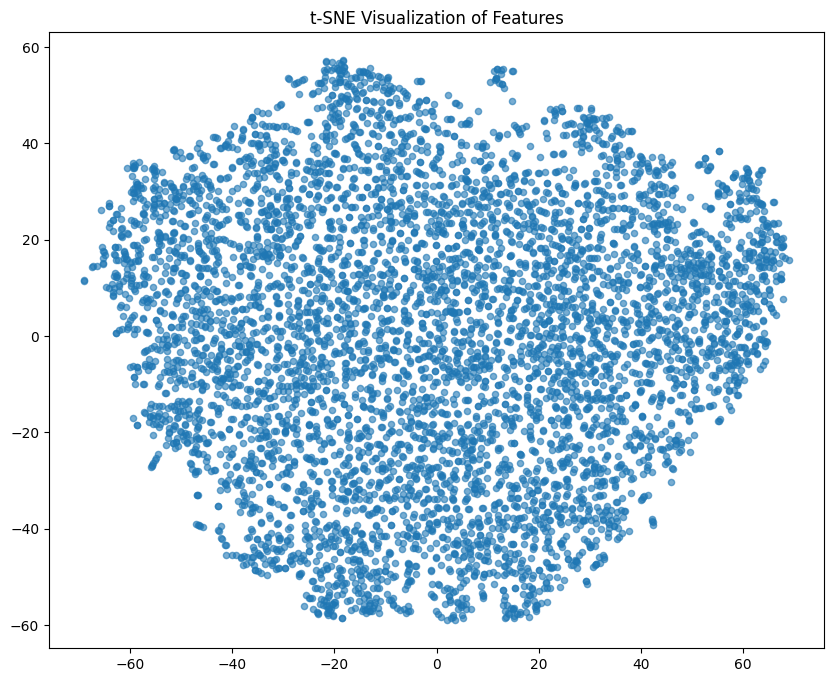

In [10]:
tsne = TSNE(n_components=2, random_state=42, max_iter=1000)
tsne_features = tsne.fit_transform(test_features)

plt.figure(figsize=(10, 8))
plt.scatter(tsne_features[:, 0], tsne_features[:, 1], s=20, alpha=0.6)
plt.title('t-SNE Visualization of Features')
plt.savefig('tsne_features.png', dpi=150, bbox_inches='tight')
plt.show()


c:\Users\admin\miniconda3\envs\deepfake-detection\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


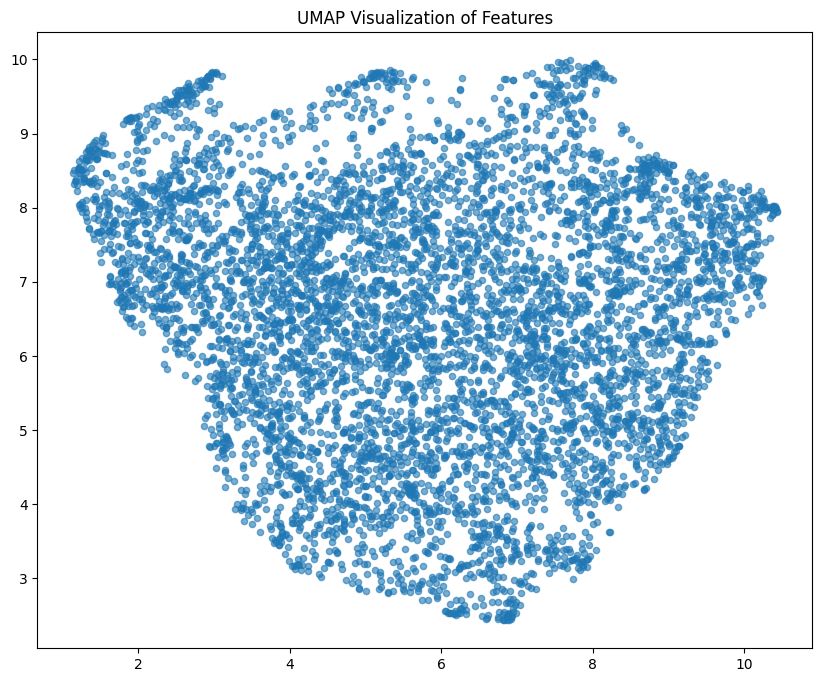

In [9]:
umap_reducer = umap.UMAP(n_components=2, random_state=42)
umap_features = umap_reducer.fit_transform(test_features)

plt.figure(figsize=(10, 8))
plt.scatter(umap_features[:, 0], umap_features[:, 1], s=20, alpha=0.6)
plt.title('UMAP Visualization of Features')
plt.savefig('umap_features.png', dpi=150, bbox_inches='tight')
plt.show()


### Fake Vs Real

In [12]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import umap
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from src.model import MFMViT
import glob
from PIL import Image

In [13]:
def load_images_from_folder(folder, transform, max_images=100):
    images = []
    files = glob.glob(f'{folder}/*.jpg') + glob.glob(f'{folder}/*.png')
    for file in files[:max_images]:
        img = Image.open(file).convert('RGB')
        images.append(transform(img).unsqueeze(0))
    return torch.cat(images)

def extract_features(model, images, device):
    model.eval()
    with torch.no_grad():
        images = images.to(device)
        tokens = model.encoder(images)
        pooled = tokens.mean(dim=1)
    return pooled.cpu().numpy()

In [14]:
# Setup
device = 'cuda' if torch.cuda.is_available() else 'cpu'
img_size = 224
batch_size = 16

transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
])

In [15]:
print("Loading images...")
real_images = load_images_from_folder('E:/data/train/real', transform, 100)
fake_images = load_images_from_folder('E:/data/train/fake', transform, 100)

# Load model
model = MFMViT(img_size=img_size).to(device)
model.load_state_dict(torch.load('checkpoints/mfm_vit_final.pth'))

# Extract features
print("Extracting features...")
real_features = extract_features(model, real_images, device)
fake_features = extract_features(model, fake_images, device)

all_features = np.vstack([real_features, fake_features])
all_labels = np.array([0]*len(real_features) + [1]*len(fake_features))

Loading images...
Extracting features...


In [20]:
len(real_images), len(fake_images)

(100, 70)

In [21]:
print("Computing t-SNE...")
tsne_features = TSNE(n_components=2, random_state=42).fit_transform(all_features)

print("Computing UMAP...")
umap_features = umap.UMAP(random_state=42).fit_transform(all_features)


Computing t-SNE...
Computing UMAP...


c:\Users\admin\miniconda3\envs\deepfake-detection\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


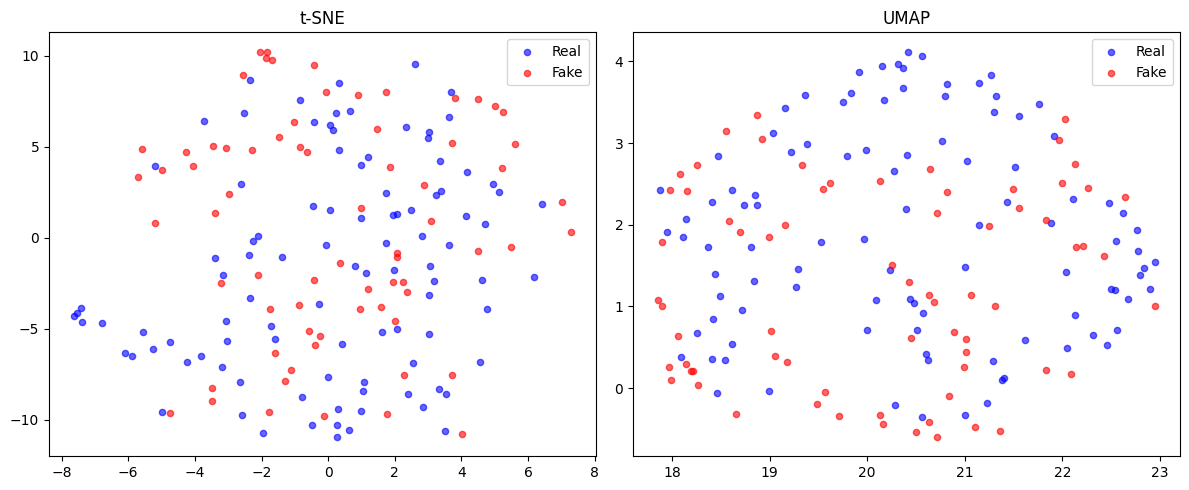

In [22]:
# Plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(tsne_features[all_labels==0, 0], tsne_features[all_labels==0, 1], 
           c='blue', label='Real', alpha=0.6, s=20)
plt.scatter(tsne_features[all_labels==1, 0], tsne_features[all_labels==1, 1], 
           c='red', label='Fake', alpha=0.6, s=20)
plt.title('t-SNE')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(umap_features[all_labels==0, 0], umap_features[all_labels==0, 1], 
           c='blue', label='Real', alpha=0.6, s=20)
plt.scatter(umap_features[all_labels==1, 0], umap_features[all_labels==1, 1], 
           c='red', label='Fake', alpha=0.6, s=20)
plt.title('UMAP')
plt.legend()

plt.tight_layout()
plt.savefig('visualization.png', dpi=300)
plt.show()

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Split data for linear probing
X_train, X_test, y_train, y_test = train_test_split(
    all_features, all_labels, test_size=0.3, random_state=42, stratify=all_labels
)

# Train logistic regression classifier
print("Training linear classifier...")
clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"\n=== Linear Probing Results ===")
print(f"Accuracy: {accuracy:.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Real', 'Fake']))
print(f"\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Training linear classifier...

=== Linear Probing Results ===
Accuracy: 0.5882

Classification Report:
              precision    recall  f1-score   support

        Real       0.62      0.77      0.69        30
        Fake       0.50      0.33      0.40        21

    accuracy                           0.59        51
   macro avg       0.56      0.55      0.54        51
weighted avg       0.57      0.59      0.57        51


Confusion Matrix:
[[23  7]
 [14  7]]


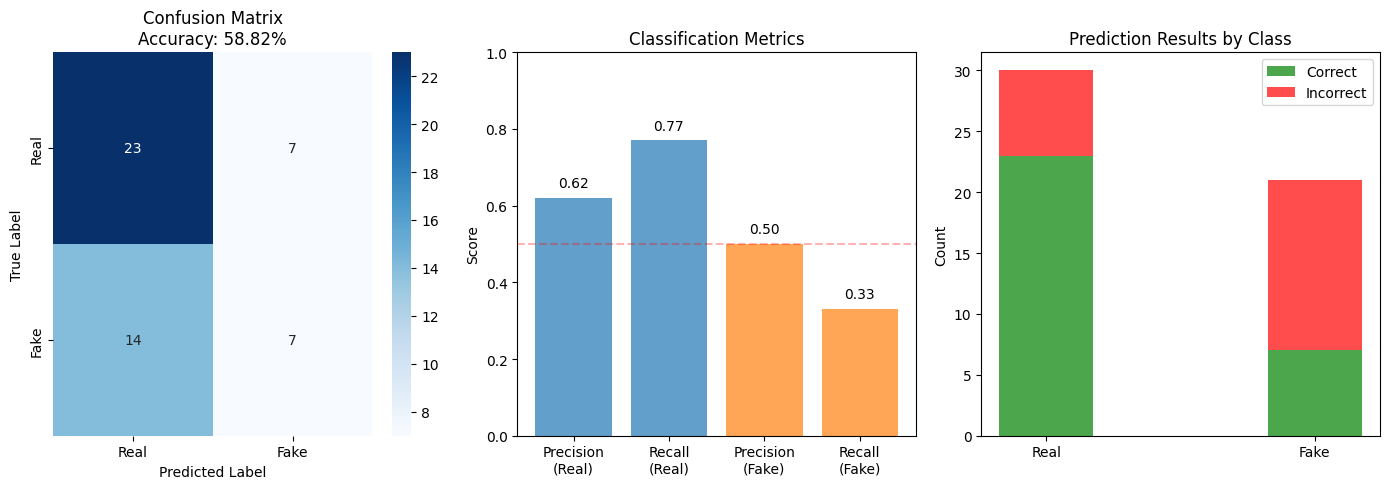


Key Insight: The model achieves 58.8% accuracy
Better at detecting Real images (77% recall) than Fake (33% recall)


In [30]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion Matrix Heatmap
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(14, 5))

# Confusion Matrix
plt.subplot(1, 3, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Real', 'Fake'], 
            yticklabels=['Real', 'Fake'])
plt.title(f'Confusion Matrix\nAccuracy: {accuracy:.2%}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Metrics Bar Chart
plt.subplot(1, 3, 2)
metrics = ['Precision\n(Real)', 'Recall\n(Real)', 'Precision\n(Fake)', 'Recall\n(Fake)']
values = [0.62, 0.77, 0.50, 0.33]
colors = ['#1f77b4', '#1f77b4', '#ff7f0e', '#ff7f0e']
bars = plt.bar(metrics, values, color=colors, alpha=0.7)
plt.ylim(0, 1)
plt.ylabel('Score')
plt.title('Classification Metrics')
plt.axhline(y=0.5, color='red', linestyle='--', alpha=0.3, label='Random')
for bar, val in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.02, 
             f'{val:.2f}', ha='center', va='bottom')

# Class Distribution
plt.subplot(1, 3, 3)
correct = [23, 7]  # Real correct, Fake correct
incorrect = [7, 14]  # Real incorrect, Fake incorrect
x = ['Real', 'Fake']
width = 0.35
plt.bar(x, correct, width, label='Correct', color='green', alpha=0.7)
plt.bar(x, incorrect, width, bottom=correct, label='Incorrect', color='red', alpha=0.7)
plt.ylabel('Count')
plt.title('Prediction Results by Class')
plt.legend()

plt.tight_layout()
plt.savefig('linear_probing_results.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nKey Insight: The model achieves {accuracy:.1%} accuracy")
print(f"Better at detecting Real images (77% recall) than Fake (33% recall)")


In [ ]:
import seaborn as sns
from sklearn.metrics i
# Confusion Matrix Heatmap
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(14, 5))

# Confusion Matrix
plt.subplot(1, 3, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Real', 'Fake'], 
            yticklabels=['Real', 'Fake'])
plt.title(f'Confusion Matrix\nAccuracy: {accuracy:.2%}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Metrics Bar Chart
plt.subplot(1, 3, 2)
metrics = ['Precision\n(Real)', 'Recall\n(Real)', 'Precision\n(Fake)', 'Recall\n(Fake)']
values = [0.62, 0.77, 0.50, 0.33]
colors = ['#1f77b4', '#1f77b4', '#ff7f0e', '#ff7f0e']
bars = plt.bar(metrics, values, color=colors, alpha=0.7)
plt.ylim(0, 1)
plt.ylabel('Score')
plt.title('Classification Metrics')
plt.axhline(y=0.5, color='red', linestyle='--', alpha=0.3, label='Random')
for bar, val in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.02, 
             f'{val:.2f}', ha='center', va='bottom')

# Class Distribution
plt.subplot(1, 3, 3)
correct = [23, 7]  # Real correct, Fake correct
incorrect = [7, 14]  # Real incorrect, Fake incorrect
x = ['Real', 'Fake']
width = 0.35
plt.bar(x, correct, width, label='Correct', color='green', alpha=0.7)
plt.bar(x, incorrect, width, bottom=correct, label='Incorrect', color='red', alpha=0.7)
plt.ylabel('Count')
plt.title('Prediction Results by Class')
plt.legend()

plt.tight_layout()
plt.savefig('linear_probing_results.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nKey Insight: The model achieves {accuracy:.1%} accuracy")
print(f"Better at detecting Real images (77% recall) than Fake (33% recall)")
